# 1. Setup and Load Data

#### 1.1 Install Dependencies and Setup

In [ ]:
!pip install tensorflow opencv-python matplotlib

In [ ]:
!pip list

In [29]:
import tensorflow as tf
import os

In [ ]:
# Avoid OOM errors by limiting the GPU's Memory growth.(otherwise tensorflow will use all of GPU) 
gpus =  tf.config.expermental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.expermenatl.set_memory_growth(gpu, True)

#### 1.2 Remove dodgy images

In [ ]:
!pip install pillow

In [30]:
import cv2 # opencv: for Computer-vision and Image-processing.
from PIL import Image # for Image handelling.

In [31]:
data_dir = 'data' # Storing address of data-dir in a varibale
img_exets = ['jpeg', 'jpg', 'bmp', 'png'] # Allowed Image-Extentions.

In [32]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        img_path = os.path.join(data_dir, image_class, image) # Get Path of Image.
        try:
            # Use OpenCV to check if the image can be read (validating corruption)
            img = cv2.imread(img_path) 
            if img is None:
                print(f'Corrupted Image: {img_path}')
                os.remove(img_path) # Remove the Image.
                continue
            # Use Pillow to check the image format
            with Image.open(img_path) as img:
                img_format = img.format.lower() # Get Image formate.
                if img_format not in img_exets:
                    print(f"Invalid image format: {img_path} (format: {img_format})")
                    os.remove(img_path)
        except Exception as e: 
            print(f"Issue with image: {img_path}, Error: {e}")
            # Optionally remove the file if needed
            # os.remove(image_path)
            

Corrupted Image: data\happy\.ipynb_checkpoints
Issue with image: data\happy\.ipynb_checkpoints, Error: [WinError 5] Access is denied: 'data\\happy\\.ipynb_checkpoints'


#### 1.3 Load Data

In [33]:
import numpy as np
from matplotlib import pyplot as plt

In [43]:
# loads data from directory and creates a dataset(preprocessed-resized, batched, labled)
db = tf.keras.utils.image_dataset_from_directory('data') # data is stores in special tensorflow formate.

Found 308 files belonging to 2 classes.


In [45]:
db_iterator = db.as_numpy_iterator() # Converts Tensorflow dataset in a formate that we can work-with using Numpy/Python-programs. 

In [46]:
batch = db_iterator.next() # Returns next batch.(db_iterator keeps track of where we are in data)

In [128]:
 # print(batch[0].max()) # In each batch two info is stored(images(numpy arrays), lables).

255.0


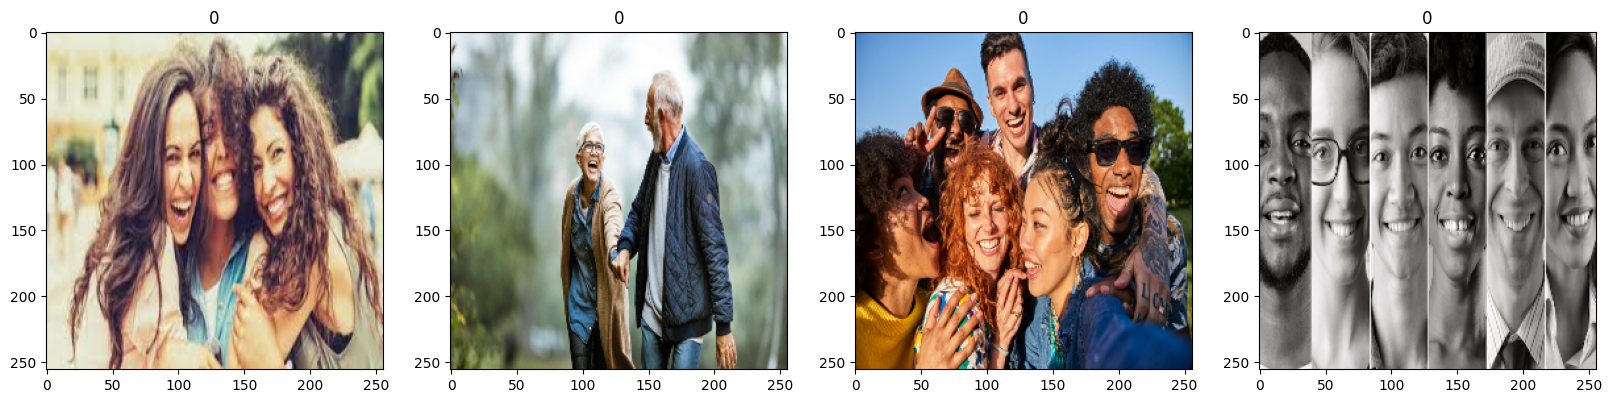

In [87]:
# Analyse the dataset.
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20)) # Makes space to show 4 images side by side.
for indx, img in enumerate(batch[0][:4]): # To traverse 4 Images from batch.
    ax[indx].imshow(img.astype(int)) # To show Image.
    ax[indx].title.set_text(batch[1][indx]) # To display index(0 ---> happy, 1 ---> sad).

# 2. Preprocess Data

#### 2.1 Scale Data

In [44]:
db = db.map(lambda img, label: (img/255, label))  # Normalizeing Image-values(Make values between "0 to 1"). for fast Computation.

In [47]:
batch[0].max() # Cross-Check(Min=0, Max=1).

1.0

#### 2.2 Split Data

In [48]:
train_size = int(len(db) * 0.7) # 70% data is used for Training Model.(training)
val_size = int(len(db) * 0.2) # 20% data is used for evaluating Model during 'Training'.(training)
test_size = int(len(db) * 0.1)  # 10% data is used for testing Model(post-training)

In [49]:
# NOTE: Shuffle data before Training, if data is not already shuffled.(for us 'keras' has already shuffled data).
train_data = db.take(train_size)
val_data = db.skip(train_size).take(val_size)
test_data = db.skip(train_size + val_size).take(test_size)

# 3. Deep Model

#### 3.1 Build Deep Learning Model(Neural Network)


In [50]:
# Import dependencies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [51]:
# Create a Model.
model = Sequential()

In [52]:
# Create a Neural Network.
# Note: only in first layer we get "input_shape = ()"   
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3))) # Convolution-step(extracting useful info from the Image)
model.add(MaxPooling2D()) # Reduces size of the Image(by taking max-value in a window)

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten()) # Convert 2D data in a 1D-array(a formate that Dense layer compute)

model.add(Dense(256, activation='relu')) # Fully Connected Layer(all input-nodes are connected to all output-nodes).
model.add(Dense(1, activation='sigmoid')) # output(range between 0 to 1. Because we are using 'sigmoid').

In [53]:
# Configure Neural Network.
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy']) # optimizer, loss-function, metrics.

In [54]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

#### 3.2 Train

In [55]:
log_dir = 'log' # To store training logs of metrices(loss, accuracy) during training

In [56]:
callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir) # Creating Instance of TensorBoard, so when we pass 'callback' 
# to model during training it will store log(history) of metrices(loss, accuracy) in 'log'-directory. And later we can visualize it.

In [57]:
# Train-Model
h = model.fit(train_data, epochs = 20, validation_data = val_data, callbacks = [callback]) # Returns Metrices-history durining training.

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 447ms/step - accuracy: 0.5197 - loss: 1.2648 - val_accuracy: 0.5312 - val_loss: 0.6892
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 436ms/step - accuracy: 0.5989 - loss: 0.6689 - val_accuracy: 0.7812 - val_loss: 0.6593
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step - accuracy: 0.7604 - loss: 0.6587 - val_accuracy: 0.8750 - val_loss: 0.5878
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - accuracy: 0.7671 - loss: 0.6176 - val_accuracy: 0.6250 - val_loss: 0.5863
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 423ms/step - accuracy: 0.7269 - loss: 0.5473 - val_accuracy: 0.8125 - val_loss: 0.5481
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 440ms/step - accuracy: 0.8481 - loss: 0.5100 - val_accuracy: 0.7656 - val_loss: 0.3825
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 437ms/step - accuracy: 0.8206 - loss: 0.3649 - val_accuracy: 0.8750 - val_loss: 0.3188
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 441ms/step - accuracy: 0.8782 - loss: 0.3772 - val_accuracy: 0.9375 - val_loss:

In [58]:
  h.history # logs of metrices(loss, accuracy) during each epoch.

{'accuracy': [0.5044642686843872,
  0.6517857313156128,
  0.78125,
  0.7053571343421936,
  0.7723214030265808,
  0.8482142686843872,
  0.8392857313156128,
  0.8660714030265808,
  0.9375,
  0.9553571343421936,
  0.9553571343421936,
  0.9732142686843872,
  0.9910714030265808,
  0.9910714030265808,
  0.9866071343421936,
  0.9910714030265808,
  0.9955357313156128,
  0.9910714030265808,
  0.9955357313156128,
  0.9955357313156128],
 'loss': [1.1658726930618286,
  0.6684961318969727,
  0.6491270065307617,
  0.665742039680481,
  0.5506221652030945,
  0.47415485978126526,
  0.35677000880241394,
  0.34473559260368347,
  0.25614213943481445,
  0.18566396832466125,
  0.11246692389249802,
  0.08673927932977676,
  0.0512327142059803,
  0.03668108209967613,
  0.0332287959754467,
  0.046093761920928955,
  0.02360263466835022,
  0.03418269380927086,
  0.020599888637661934,
  0.017342230305075645],
 'val_accuracy': [0.53125,
  0.78125,
  0.875,
  0.625,
  0.8125,
  0.765625,
  0.875,
  0.9375,
  0.95312

#### 3.3 Plot Performance

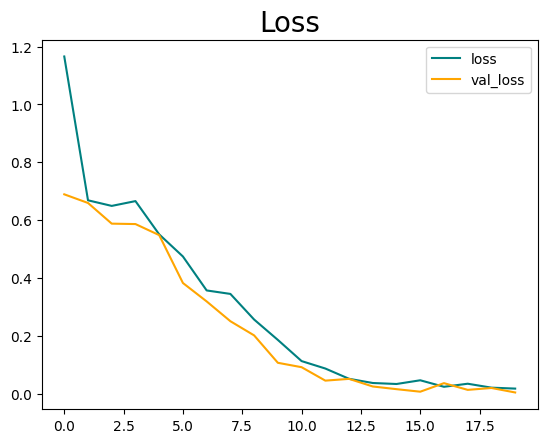

In [59]:
# Visualizing Training-loss and Validation_loss.
plt.plot(h.history['loss'], color='teal', label='loss')
plt.plot(h.history['val_loss'], color='orange', label='val_loss')
plt.title('Loss', fontsize=20)
plt.legend(loc="upper right") # To place lables
plt.show()

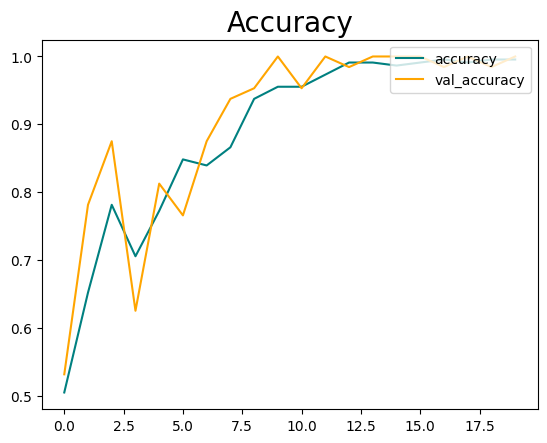

In [60]:
# Visualizing Training-Accuracy and Validation-Accuracy
plt.plot(h.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(h.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
plt.title('Accuracy', fontsize = 20)
plt.legend(loc="upper right")
plt.show()

# 4. Evaluate Performance

#### 4.1 Evaluate

In [61]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy # Metrics: Measurement used to evaluate ML-Model percormance.

In [62]:
# Create Instances.
p = Precision()
r = Recall()
ba = BinaryAccuracy()

In [63]:
# Evaluate Model on test-data.
for batch in test_data.as_numpy_iterator():
    img, label = batch
    result = model.predict(img) # Model prediction on Image.
    p.update_state(label, result)
    r.update_state(label, result)
    ba.update_state(label, result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


In [64]:
# Print Metrices.
print(f'Precision: {p.result()}, Recall: {r.result()}, Accuracy: {ba.result()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


#### 4.2 Test

In [65]:
import cv2 # Import openCV to read Images for Testing.

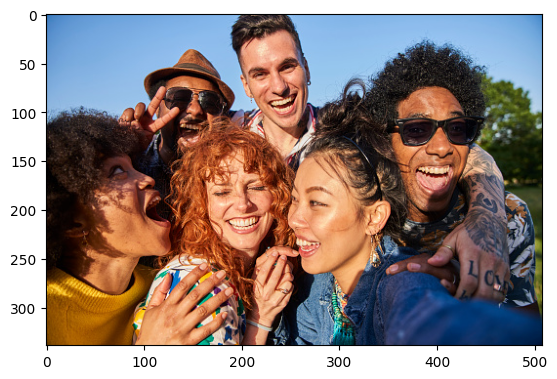

In [72]:
img = cv2.imread('happy.jpg') # Read Image(reads image id image is a valid Image).
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # cv2 reads images as BGR, so we need to convert it to RGB
plt.show() # to remove binary formate og image

In [67]:
img = tf.image.resize(img, (256,256))
#plt.imshow(img.numpy().astype(int))
# plt.show()

In [70]:
result = model.predict(np.expand_dims(img/255, 0))# our Model expects input to be in a batch, so we need to convert single image as a batch.
# also NORMALIZE the Image.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [71]:
if result > 0.5:
    print("Sad")
else:
    print("Happy")

Sad
